# Model-3

In [1]:
import tensorflow as tf
import numpy as np
from dataset import Dataset, load_datasets
from config import get_dataset_path
from layers import *
from networks import *
from model import Model
from dbase import build_dbase
from evaluation import print_accuracy, plot_search_results

In [4]:
tr_data_path  = get_dataset_path("train/5557_300_128_128_1_uint8_aug2.npy")
va_data_path  = get_dataset_path("valid/550_300_128_128_1_uint8_aug2.npy")
model_path    = "models/003-v4/"

## Dataset

In [5]:
%%time
tr_dataset, va_dataset = load_datasets(tr_data_path, va_data_path)
print('-'*50)

/netforge/datasets/private/roman/coins/2017-11-29/datasets/train/5557_300_128_128_1_uint8_aug2.npy:
 [5557, 300, 128, 128, 1] uint8
/netforge/datasets/private/roman/coins/2017-11-29/datasets/valid/550_300_128_128_1_uint8_aug2.npy:
 [550, 300, 128, 128, 1] uint8
--------------------------------------------------
CPU times: user 640 ms, sys: 1min 15s, total: 1min 15s
Wall time: 2min 54s


## Build 

In [6]:
%%time
out_dims       = 100
margin         = .5
network        = simple_conv

# v1: d=300 m=1 s=15k lr=1e-6 acc=87.3
# v2: d=300 m=3 s=15k lr=1e-4 acc=93.3
# v3: d=300 m=5 s=30k lr=1e-4 acc=97.3
# v4: d=100 m=5 s=100k lr=1e-4 acc=97.9 ..

acc_batch_size = 300
image_shape    = list(tr_dataset.data.shape[-3:])
model          = Model(image_shape, out_dims, acc_batch_size)
model.build(network)

CPU times: user 5.8 s, sys: 0 ns, total: 5.8 s
Wall time: 5.97 s


## Train

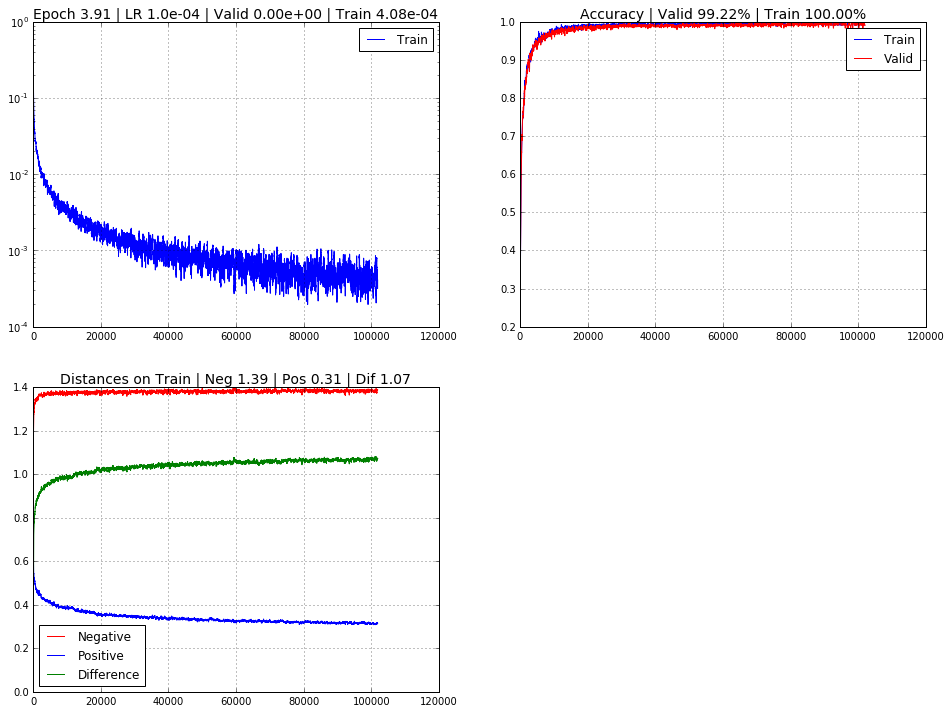

--------------------------------------------------
CPU times: user 13min 54s, sys: 1min 48s, total: 15min 43s
Wall time: 14min 53s


In [10]:
%%time
model.train(
    step_num   = 150000, 
    batch_size = 64,
    lr         = 1e-4, 
    log_every  = 100,
    tr_dataset = tr_dataset,
    va_dataset = va_dataset,
    margin     = margin,
    log_scale  = True)

model.save(model_path)
print('-'*50)

## Database

In [50]:
%%time
ethalons  = tr_dataset.get_ethalons()  # tr_dataset va_dataset
augmented = tr_dataset.get_augmented() # get_augmented() get_ethalons()

dbase     = build_dbase(model, ethalons, augmented)
print('-'*50)

Ethalons : [5557, 128, 128, 1] float32
Augmented: [5557, 128, 128, 1] float32
Database : [5557, 100] float64
--------------------------------------------------
CPU times: user 1.3 s, sys: 3.97 s, total: 5.27 s
Wall time: 5.08 s


## Accuracy

In [51]:
%%time
print_accuracy(dbase, augmented, 5)

Database   : [5557, 100]
Request    : [5557, 128, 128, 1]
Performance: 744 img/sec
--------------------------------------------------
Accuracy@1: 97.9%
Accuracy@2: 99.0%
Accuracy@3: 99.5%
Accuracy@4: 99.7%
Accuracy@5: 99.8%
--------------------------------------------------
CPU times: user 7.7 s, sys: 72 ms, total: 7.78 s
Wall time: 7.54 s


## Search

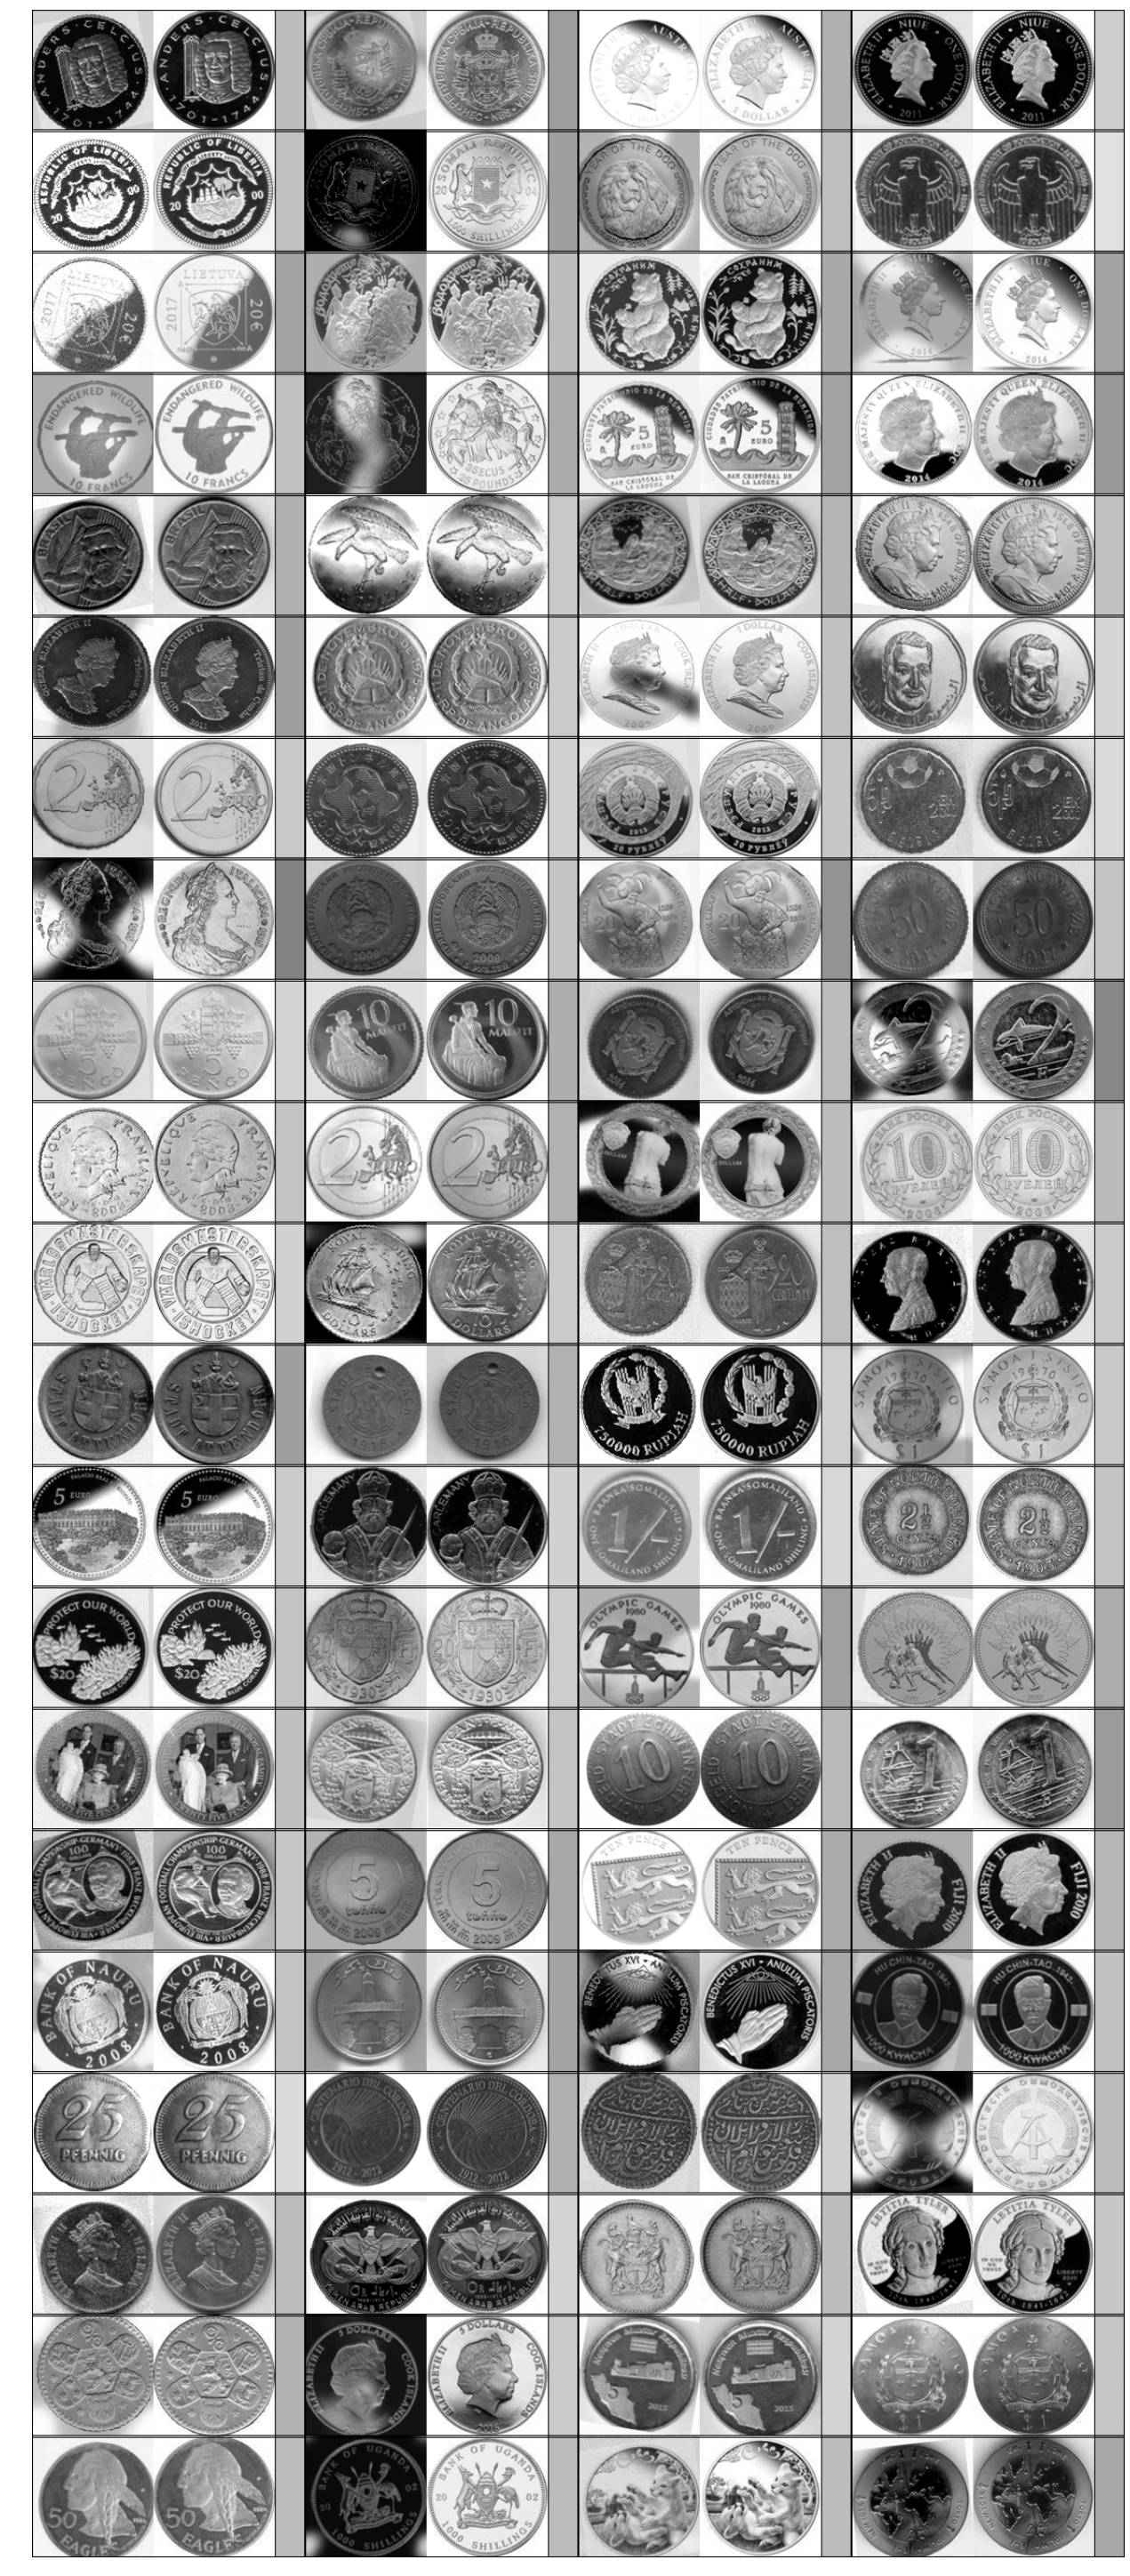

In [52]:
plot_search_results(dbase, augmented, num=84, cols=4)

## Restore

In [7]:
%time
model.restore(model_path)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.58 µs
INFO:tensorflow:Restoring parameters from models/003-v4/
